In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [2]:
env = gym.make("CartPole-v1")

print("Observation space:", env.observation_space)
# obs = [cart_position, cart_velocity, pole_angle, pole_angular_velocity]
print("Action space:", env.action_space)
print("Reward: +1 per time step until pole falls or cart goes out of bounds.")
print("Goal: keep the pole upright as long as possible (max 500 steps).")


Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space: Discrete(2)
Reward: +1 per time step until pole falls or cart goes out of bounds.
Goal: keep the pole upright as long as possible (max 500 steps).


In [4]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ActorNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, action_dim):
        super(ActorNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
    def forward(self, x):
        out = self.net(x)
        return out
class CriticNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CriticNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        out = self.net(x)
        return out
# Actor-Critic Network
class ActorCritic(nn.Module):
    def __init__(self, input_dim, hidden_dim, action_dim):
        super(ActorCritic, self).__init__()
        # self.shared = nn.Sequential(
        #     nn.Linear(input_dim, hidden_dim),
        #     nn.ReLU(),
        # )
        self.actor = ActorNet(input_dim, hidden_dim, action_dim)     # logits for actions
        self.critic = CriticNet(input_dim, hidden_dim)             # state value

    def forward(self, x):
        x = self.shared(x)
        return self.actor(x), self.critic(x)


# Discounted return calculation
def compute_returns(rewards, gamma):
    R = 0
    returns = []
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    return returns


# Train loop
def train_ac(env_name="CartPole-v1", episodes=400, gamma=0.95, hidden_dim=128, actor_lr=4e-3, critic_lr=4e-3):
    env = gym.make(env_name)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n

    model = ActorCritic(obs_dim, hidden_dim, act_dim).to(device)
    actor, critic = model.actor, model.critic
    optimizer_actor = torch.optim.Adam(actor.parameters(), lr=actor_lr)
    optimizer_critic = torch.optim.Adam(critic.parameters(), lr=critic_lr)
    all_rewards = []
    for episode in range(episodes):
        obs = env.reset()[0]
        log_probs, values, rewards = [], [], []
        done = False
        
        while not done:
            obs_tensor = torch.tensor(obs, dtype=torch.float32).to(device)
            logits, value = actor(obs_tensor), critic(obs_tensor)

            probs = torch.softmax(logits, dim=-1)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()

            log_probs.append(dist.log_prob(action))
            values.append(value)
            obs, reward, terminated, truncated, _ = env.step(action.item())
            rewards.append(reward)
            done = terminated or truncated
   
        # Compute returns and advantage
        returns = compute_returns(rewards, gamma)
        returns = torch.tensor(returns, dtype=torch.float32).to(device)
        values = torch.cat(values).squeeze()
        log_probs = torch.stack(log_probs)
        

        advantage = returns - values
        advantage = advantage/10
        
        # Compute loss
        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()
        # loss = actor_loss + critic_loss

        # Update
        optimizer_actor.zero_grad()
        optimizer_critic.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        optimizer_actor.step()
        optimizer_critic.step()

        # Log
        total_reward = sum(rewards)
        all_rewards.append(total_reward)
        print(f"Episode {episode + 1}, Reward: {total_reward:.2f}, ActorLoss: {actor_loss.item():.4f}. CriticLoss: {critic_loss.item():.4f}")

    env.close()
    return model, all_rewards


# Train it
model, all_rewards = train_ac()


C:\Users\86596\anaconda3\envs\xu\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1, Reward: 19.00, ActorLoss: 0.4965. CriticLoss: 0.6817
Episode 2, Reward: 19.00, ActorLoss: 0.4840. CriticLoss: 0.6651
Episode 3, Reward: 24.00, ActorLoss: 0.5470. CriticLoss: 0.8826
Episode 4, Reward: 24.00, ActorLoss: 0.5580. CriticLoss: 0.8633
Episode 5, Reward: 16.00, ActorLoss: 0.3962. CriticLoss: 0.4854
Episode 6, Reward: 30.00, ActorLoss: 0.6651. CriticLoss: 1.1036
Episode 7, Reward: 43.00, ActorLoss: 0.7523. CriticLoss: 1.5512
Episode 8, Reward: 32.00, ActorLoss: 0.6168. CriticLoss: 1.1266
Episode 9, Reward: 29.00, ActorLoss: 0.5771. CriticLoss: 0.9869
Episode 10, Reward: 20.00, ActorLoss: 0.4100. CriticLoss: 0.5917
Episode 11, Reward: 21.00, ActorLoss: 0.4166. CriticLoss: 0.6231
Episode 12, Reward: 17.00, ActorLoss: 0.4938. CriticLoss: 0.4524
Episode 13, Reward: 71.00, ActorLoss: 0.8519. CriticLoss: 2.1039
Episode 14, Reward: 20.00, ActorLoss: 0.3872. CriticLoss: 0.5377
Episode 15, Reward: 23.00, ActorLoss: 0.4300. CriticLoss: 0.6584
Episode 16, Reward: 24.00, ActorLo

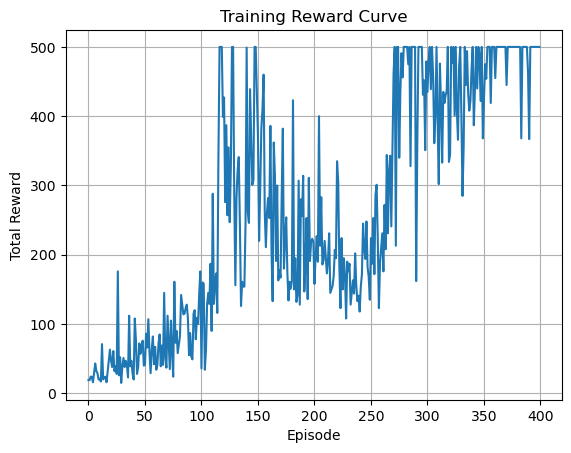

In [5]:
import matplotlib.pyplot as plt

plt.plot(all_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Reward Curve')
plt.grid(True)
# plt.save()
plt.show()


In [6]:
torch.save(model, 'cartpole.pt')